## Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import visdom

from util.validation_set_split import validation_split
from model.ConvAE import ConvAE

## download and load MNIST dataset

In [2]:
mnist_train = datasets.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = datasets.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

## Make validation dataset

In [3]:
mnist_train, mnist_val = validation_split(mnist_train)

## Set hyperparameters

In [4]:
batch_size = 16
learning_rate = 0.0002
num_epoch = 500
validate_every = 5
max_patience = 3 # for early stopping

## Set dataloaders

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)
val_loader = torch.utils.data.DataLoader(mnist_val,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

## Use GPU if GPU is available

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ConvAE().to(device)

## You can load pretrained weight

In [7]:
#model.load_state_dict(torch.load('pytorch_weight/ConvAE.pt'))

## Loss function, Optimizer

In [8]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Set visdom
### please run visdom server before you implement (python -m visdom.server)

In [9]:
vis = visdom.Visdom(port=8097)
plot_opts = dict(showlegend=True,
    width=900, height=600, title='MNIST Training',
    xlabel='epoch', ylabel='Loss')

## Train

In [10]:
best_loss = 100.0
last_loss = 0
last_intput = None
last_output = None
patience = 0
for epoch in range(num_epoch):
    starting_time = time.time()
    loss_log = []
    for i,[image,label] in enumerate(train_loader):
        x = Variable(image).to(device)
        optimizer.zero_grad()
        # ===============forward=================
        output = model.forward(x)
        # ===============backward=================
        loss = loss_func(output,x)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        last_intput = x
        last_output = output

    train_loss = np.mean(loss_log)
    proc_time = (time.time()-starting_time)
    
    # visualization using visdom
    if 'input_win' not in globals():
        global input_win
        input_win = vis.images(last_intput, opts=dict(title='input images'))
    else:
        vis.images(last_intput, win=input_win, opts=dict(title='input images'))
        
    if 'output_win' not in globals():
        global output_win
        output_win = vis.images(last_output, opts=dict(title='output images'))
    else:
        vis.images(last_output, win=output_win, opts=dict(title='output images'))
        
    if 'train_win' not in globals():
        global train_win
        train_win = vis.line(X=[epoch], Y=[train_loss],
            opts=plot_opts, name='Training loss')
    else:
        vis.line(X=[epoch], Y=[train_loss],
        win=train_win, opts=plot_opts, name='Training loss',update='append')
        
    # check validation dataset
    if(epoch % validate_every == 0):
        with torch.no_grad():
            val_loss_log = []
            for image,label in val_loader:
                x = Variable(image).to(device)
                output = model.forward(x)
                loss = loss_func(output,x)
                val_loss_log.append(loss.item())
            val_loss = np.mean(val_loss_log)
            # visualization
            vis.line(X=[epoch], Y=[val_loss],win=train_win, 
                opts=dict(markers=True, showlegend=True), name='Validation loss', update='append')
            if(val_loss < best_loss):
                patience = 0
                best_loss = val_loss
            else:
                patience += 1

    if(patience > max_patience):
        print("early stopping at {}".format(epoch))
        break
    if(abs(last_loss - train_loss) < 1e-6):
        print("weights ard no longer updated")
        break
    last_loss = train_loss
    print("\rEpoch : {} , loss : {:.4f}, took {} sec".format(epoch,train_loss,int(proc_time)), end="")
    if(epoch % 10 == 0):
        print("\rEpoch : {} , loss : {:.4f}, took {} sec".format(epoch,train_loss,int(proc_time)))

Epoch : 0 , loss : 0.0432, took 11 sec
Epoch : 10 , loss : 0.0175, took 11 sec
Epoch : 20 , loss : 0.0161, took 12 sec
Epoch : 30 , loss : 0.0155, took 11 sec
Epoch : 40 , loss : 0.0151, took 12 sec
Epoch : 50 , loss : 0.0148, took 12 sec
Epoch : 60 , loss : 0.0145, took 12 sec
Epoch : 70 , loss : 0.0143, took 12 sec
Epoch : 80 , loss : 0.0141, took 12 sec
Epoch : 90 , loss : 0.0140, took 11 sec
Epoch : 100 , loss : 0.0139, took 11 sec
Epoch : 110 , loss : 0.0138, took 12 sec
Epoch : 120 , loss : 0.0137, took 12 sec
Epoch : 130 , loss : 0.0136, took 11 sec
Epoch : 134 , loss : 0.0135, took 12 secweights ard no longer updated


## Save model

In [12]:
torch.save(model.state_dict(), 'pytorch_weight/ConvAE.pt')

## Check with Train Image

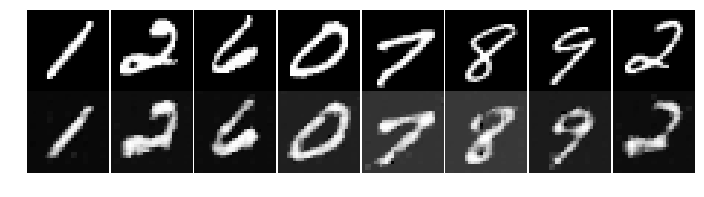

In [14]:
%matplotlib inline

fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0, hspace=0)
num_to_print = 8
index = 5

out_img = torch.squeeze(output.cpu().data)

for i in range(num_to_print):
    ax1 = fig.add_subplot(2, num_to_print, 1+i)
    ax2 = fig.add_subplot(2, num_to_print, (num_to_print+1)+i)
    ax1.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    ax2.imshow(out_img[i].numpy(),cmap='gray')
    ax1.axis('off')
    ax2.axis('off')

## Filter Visualization

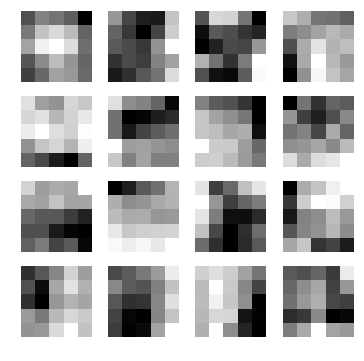

In [29]:
# first convolution layer
weight = torch.squeeze(model.encoder[0].weight.cpu().data)
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

for i in range(16):
    ax = fig.add_subplot(4,4, 1+i)
    ax.imshow(weight[i], 'gray')
    ax.axis('off')